# 0. Setup.

In [1]:
# Imports.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Custom libs.
import nbimporter
import plot_utils

# Reload the main.ipynb for any change in imported libs.
import importlib
importlib.reload(plot_utils)

# To plot orders on the Korean map.
from plot_utils import plot_orders

# Seeds.
SEED = 42
np.random.seed(SEED)

In [33]:
def plot_3d(x, y, plot_colorbar=True):
    from mpl_toolkits.mplot3d import Axes3D
    
    # Create 3D plot
    fig = plt.figure(figsize=(20, 12))
    ax  = fig.add_subplot(111, projection='3d')
    
    # Scatter plot using spatial (x, y) and temporal (z) data
    scatter = ax.scatter(x[:, 0], x[:, 1], x[:, 2], c=y, cmap='tab10', edgecolor='k', s=200)
    
    # Draw projection lines to XY, XZ, and YZ planes
    for i in range(x.shape[0]):
        ax.plot([x[i, 0], x[i, 0]], [x[i, 1], x[i, 1]], [0, x[i, 2]], color='gray', linestyle='dotted', alpha=0.5)  # XY plane
        # ax.plot([x[i, 0], x[i, 0]], [0, x[i, 1]], [x[i, 2], x[i, 2]], color='gray', linestyle='dotted', alpha=0.5)  # XZ plane
    
    # Labels
    ax.set_xlabel("Latitude")
    ax.set_ylabel("Longitude")
    ax.set_zlabel("Time")
    
    # Add colorbar
    if plot_colorbar:
        plt.colorbar(scatter, label="Cluster Label")
    
    # Show plot
    plt.show()

# 1. Data.

In [34]:
df = pd.read_excel('./data/20250127_100yrs_Order_List_20250124.xlsx')  
df = df.rename(columns={'date': 'time'})

# Append `deadline` axis.
df['time_start'] = pd.to_datetime(df['time'], format='%H:%M')
df['time_start'] = df['time_start'].dt.hour * 60 + df['time_start'].dt.minute

# Generate random offsets (10 mins to 12 hours)
random_offsets = np.random.randint(10, 60 * 6, size=len(df))

# Compute 'deadline' in minutes from 00:00
df['time_end'] = df['time_start'] + random_offsets


# Select only necessary cols.
cols = ['time', 'latitude', 'longitude', 'time_start', 'time_end']
df = df[cols]

df.head()

,time,latitude,longitude,time_start,time_end
0,07:30,37.551364,127.134728,450,786
1,07:30,37.489210,127.144964,450,646
2,07:30,37.601524,127.042343,450,702
3,07:30,37.571969,127.087083,450,545
4,07:30,37.610418,127.080087,450,743


# 2. Test - ST-DBSCAN.

In [35]:
df['time'].unique()

array(['07:30', '08:00', '09:30', '12:30'], dtype=object)

07:30
0.121
0.09075
22
[ 0  1  1  1  1  1  1  1  1  2  3  4  2 -1  3 -1  0  1  0  5  1  1  1  1
  1  1  5  6 -1  1  7  6 -1  8  2  2  9  1  1  1  1 10  1  4  5  1 -1  1
  1  2 -1 10 -1  2 -1  1  1  1  1  1  1  1 -1  1  1  1  1  3  1  1 11 -1
  3  1 -1 -1  1  8  7 -1  8  1  1 -1 -1  5  2  1  9 -1  2  1  1 -1 -1  0
  2  5 11  3  1  1  1 -1  0  1  1 -1 -1  5 -1  1]


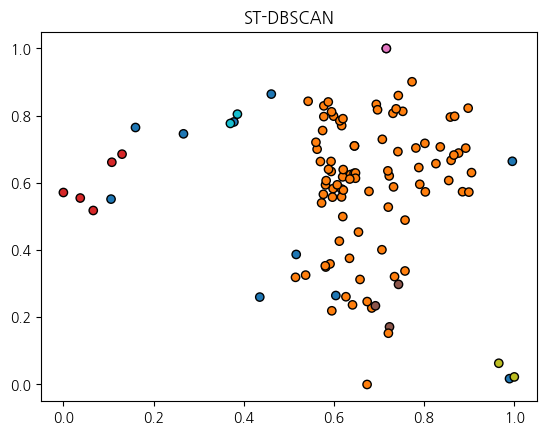

C:\Users\aruwa\anaconda3\envs\algolab_rnd\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


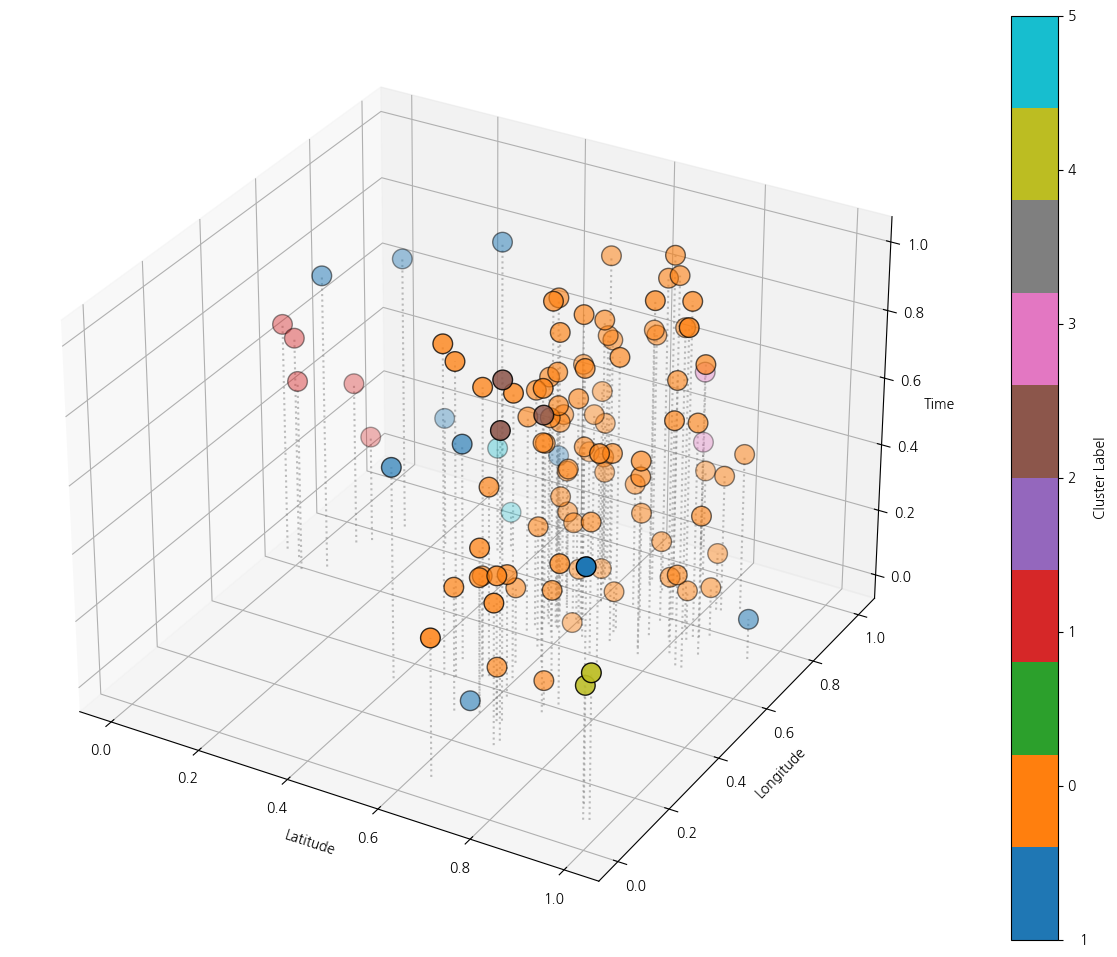

In [55]:
# Normalize.
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Iter times, cluster and plot.
min_samples   = 2
n_clusters    = 10
time_ratio    = 0.75
outlier_ratio = 0.2

for t in df['time'].unique():
    print(t)
    x = df[df['time'] == t]
    x = x[['latitude', 'longitude', 'time_end']]
    x = scaler.fit_transform(x)  # Normalize all dimensions to [0,1]
    
    # Cluster.
    from st_dbscan import ST_DBSCAN
    for eps1 in range(10, 1000):
        eps1 /= 1000
        eps2  = eps1 * time_ratio
        model = ST_DBSCAN(eps1        = eps1,         # Maximum spatial distance for clustering.
                          eps2        = eps2,         # Maximum temporal distance for clustering.
                          min_samples = min_samples,  # Minimum number of points to form a cluster.
                          metric      = 'euclidean')  # Distance metric. Supports various options like 'euclidean', 'cosine', 'manhattan', etc.
        
        # Methods.
        model.fit(X=x)    

        if np.sum(model.labels == -1) < len(model.labels)*outlier_ratio:
            # if n_clusters in model.labels:
            if len(np.unique(model.labels)) >= n_clusters:
                print(eps1)
                print(eps2)
                print(np.sum(model.labels == -1))
                print(model.labels)
                break
    
    model = ST_DBSCAN(eps1=eps1, eps2=eps2, min_samples=min_samples)

    model = ST_DBSCAN(eps1=0.25, eps2=0.05, min_samples=2)
    model.fit(X=x)
    y_pred = model.labels
    
    # Plot clusters
    plt.scatter(x[:, 0], x[:, 1], c=y_pred, cmap='tab10', edgecolor='k')
    plt.title("ST-DBSCAN")
    plt.show()
    plot_3d(x, y_pred)

    break

0.145
0.10874999999999999
22
[ 0  0  0  0  0  0  0  0  0  1  0  1  1 -1  1 -1  0  0  0  0  0  0  0  0
  0  0  0  0 -1  0  0 -1 -1 -1  1  1  1  0 -1  0  0  0  0  0  0  0 -1  0
  0 -1 -1 -1  1  0  1  0  0  0  0  0  0  0 -1  0  0  0  0  1  0  0 -1 -1
 -1  0  0  0  0 -1  0  0 -1  0  0 -1  0  0  1  0  1  0  1  0  0  0 -1  0
  1  0 -1  1  0  0  0 -1  0 -1  0  0  0  0  0  0]
22
[ 0  0  0  0  0  0  0  0  0  1  0  1  1 -1  1 -1  0  0  0  0  0  0  0  0
  0  0  0  0 -1  0  0 -1 -1 -1  1  1  1  0 -1  0  0  0  0  0  0  0 -1  0
  0 -1 -1 -1  1  0  1  0  0  0  0  0  0  0 -1  0  0  0  0  1  0  0 -1 -1
 -1  0  0  0  0 -1  0  0 -1  0  0 -1  0  0  1  0  1  0  1  0  0  0 -1  0
  1  0 -1  1  0  0  0 -1  0 -1  0  0  0  0  0  0]


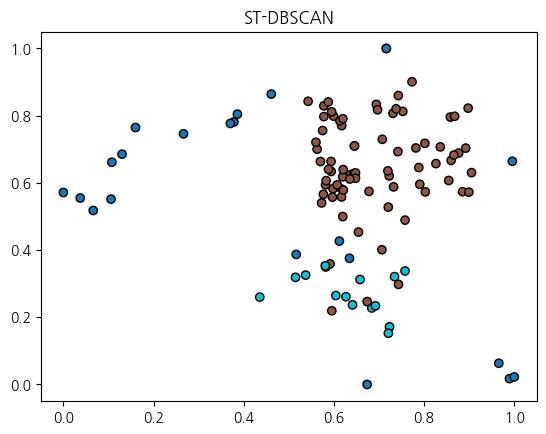

C:\Users\aruwa\anaconda3\envs\algolab_rnd\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


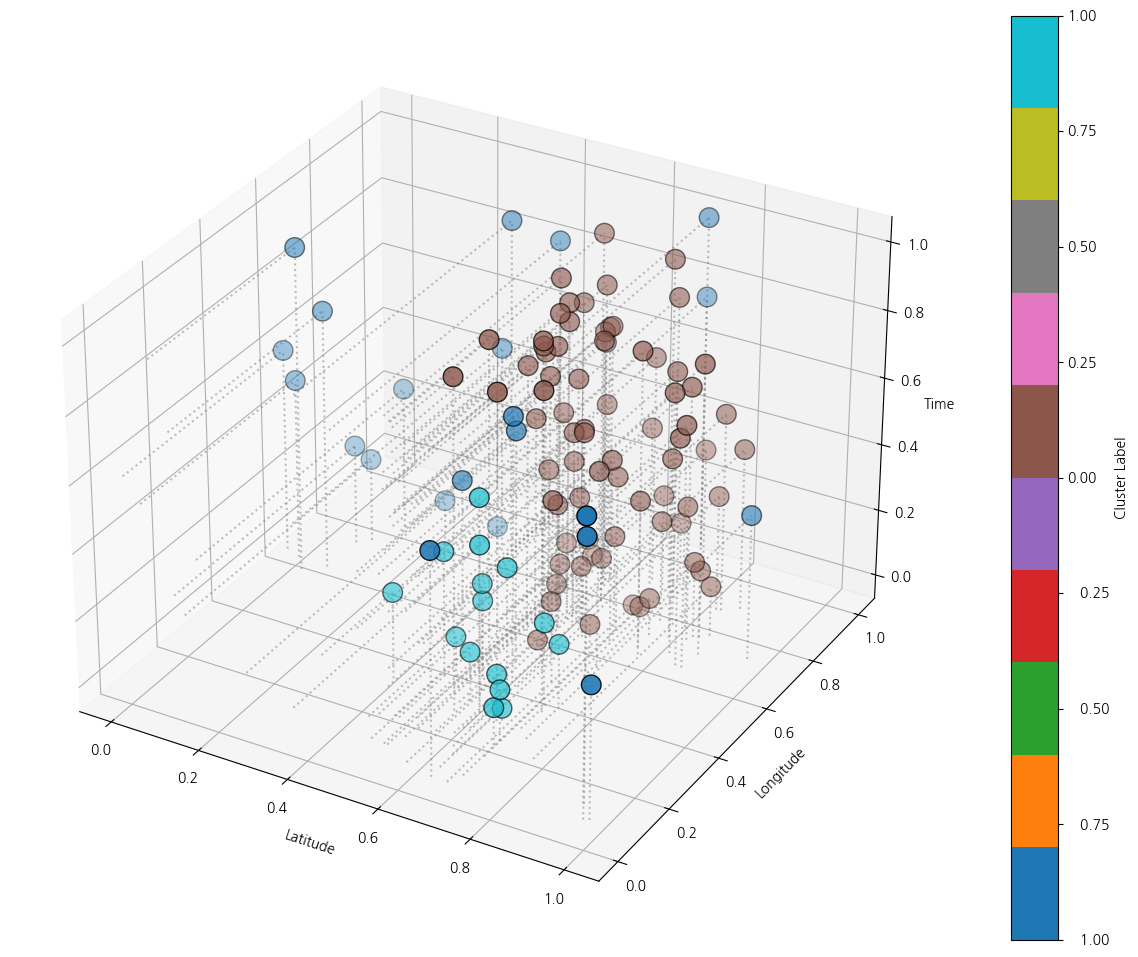

In [17]:
x = df[df['time'] == '07:30']
x = x[['latitude', 'longitude', 'time_end']]
x = scaler.fit_transform(x)  # Normalize all dimensions to [0,1]

# Cluster.
from st_dbscan import ST_DBSCAN
for eps1 in range(10, 1000):
    eps1 /= 1000
    eps2  = eps1 * time_ratio
    model = ST_DBSCAN(eps1        = eps1,         # Maximum spatial distance for clustering.
                      eps2        = eps2,         # Maximum temporal distance for clustering.
                      min_samples = min_samples,  # Minimum number of points to form a cluster.
                      metric      = 'euclidean')  # Distance metric. Supports various options like 'euclidean', 'cosine', 'manhattan', etc.
    
    # Methods.
    model.fit(X=x)    

    if np.sum(model.labels == -1) < len(model.labels)*outlier_ratio:
#        if n_clusters in model.labels:
        if len(np.unique(model.labels)) >= n_clusters:
            print(eps1)
            print(eps2)
            print(np.sum(model.labels == -1))
            print(model.labels)
            break

model = ST_DBSCAN(eps1=eps1, eps2=eps2, min_samples=min_samples)

#model = ST_DBSCAN(eps1=0.25, eps2=0.2, min_samples=2)
model.fit(X=x)
y_pred = model.labels

print(np.sum(model.labels == -1))
print(model.labels)

# Plot clusters
plt.scatter(x[:, 0], x[:, 1], c=y_pred, cmap='tab10', edgecolor='k')
plt.title("ST-DBSCAN")
plt.show()
plot_3d(x, y_pred)

KeyError: 'cluster'

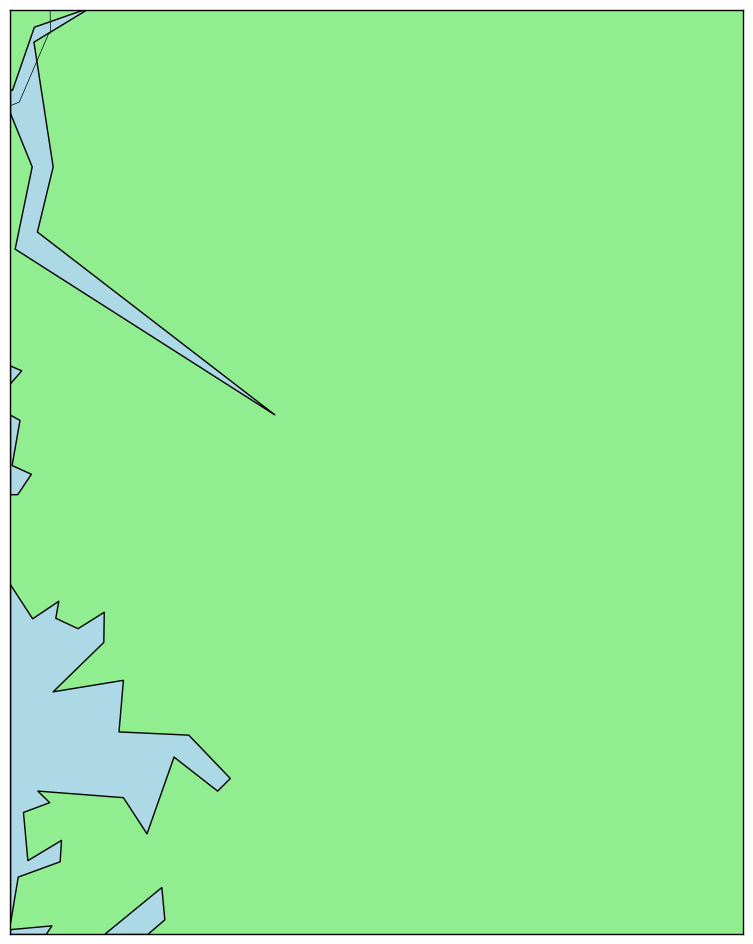

In [8]:
plot_orders(df, 
            plot_Han_river=False, 
            city='Seoul', 
            color_by_cluster=True, 
            zoom_ratio=2, 
            figsize=(20, 12), 
            cmap='tab10')